In [1]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


### Read processed files and create big matrix with all rows

In [2]:
setwd("~/Downloads/data2/")
system("find . -type f -name \"*.log\" -print0 | xargs -0 cat > ALL.data")
df_all <- data.frame(fread("ALL.data", sep=",", header = F), stringsAsFactors=F)
dim(df_all)
df_all <- df_all[complete.cases(df_all),]
dim(df_all)

[1] 506823   1626

[1] 506557   1626

### Experiment parameters

In [3]:
# Resolution for target frequency [0-100]
input_resolution <- 0.25
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, input_resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )) # Buckets of possible classes

### Matrix creation from data

In [95]:
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 4
dimensions <- 4 # Number of channels
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(0, nrow = rows, ncol = num_classes)
ind_data <- seq(from=1,to=rows)

In [149]:
# Reshape dataframe to matrix slices
X[ind_data, , 1] <- as.matrix(df_all[ind_data, 1:406])
X[ind_data, , 2] <- normalized(as.matrix(df_all[ind_data, 406:((406 * 2) - 1)]))
X[ind_data, , 3] <- normalized(as.matrix(df_all[ind_data, (406 * 2):((406 * 3) - 1)]))
X[ind_data, , 4] <- normalized(as.matrix(df_all[ind_data, (406 * 3):((406 * 4) - 1)]))
Y <- to_categorical(df_all[ind_data, 1626:1626] / 0.0864, num_classes) 

dim(X)
dim(Y)

ERROR: Error in parse(text = x, srcfile = src): <text>:5:1: unexpected symbol
4: X[ind_data, , 3] <- normalized(as.matrix(df_all[ind_data, (406 * 2):((406 * 3) - 1)])
5: X
   ^


### Check that target is not in the trainind data

In [6]:
print(paste0("Check for target 1:"))
flags <- c()
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1626:1626] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

flags <- c()
print(paste0("Check for target 2:"))
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1625:1625] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

[1] "Check for target 1:"
flags
 FALSE   TRUE 
506548      9 
[1] "Check for target 2:"


In [ ]:
#ind_remove_no_target <- which(apply(Y,1,sum)==1)
#paste0("Removing ",length(ind_remove_no_target[ind_remove_no_target==TRUE])," rows with NO target")

#X <- X[ind_remove_no_target,,]
#Y <- Y[ind_remove_no_target,]

#dim(X)
#dim(Y)

In [109]:
stopifnot(which(is.na(Y))==FALSE)
stopifnot(which(is.na(X))==FALSE)

In [110]:
# Split train/test
smp_size <- floor(0.98 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 496425    406      4

[1] 496425    162

[1] 10132   406     4

[1] 10132   162

### EDA of data

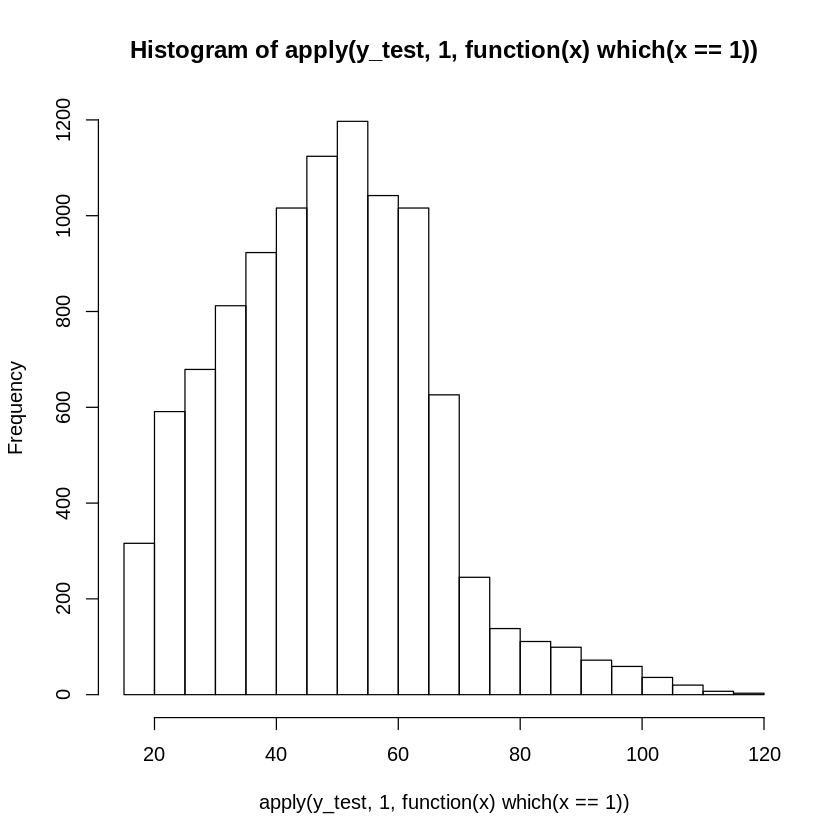

In [111]:
hist(apply(y_test,1,function(x) which(x==1)))

### NN train

In [112]:
top_8_categorical_accuracy <-
  custom_metric("rec_at_8", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 8)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })

In [113]:
checkpoint_dir <- "~/Downloads/test/"
if (T) {
    unlink(checkpoint_dir, recursive = TRUE)
    dir.create(checkpoint_dir)
    filepath <- file.path(checkpoint_dir, "weights.{epoch:02d}-{val_loss:.2f}.hdf5")


# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = filepath,
  save_weights_only = TRUE,
  period = 5,
  verbose = 1
)
}
    

# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(406, 4)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%
layer_separable_conv_1d(
    kernel_size = 2,
    filters = 4,
    depth_multiplier = 20
  ) %>%
  layer_max_pooling_1d(pool_size = 4) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_8_categorical_accuracy
        )
)
summary(model) # Plot summary

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_23 (SeparableConv1 (None, 403, 8)                  488         
________________________________________________________________________________
max_pooling1d_23 (MaxPooling1D)     (None, 201, 8)                  0           
________________________________________________________________________________
dropout_23 (Dropout)                (None, 201, 8)                  0           
________________________________________________________________________________
batch_normalization_23 (BatchNormal (None, 201, 8)                  32          
________________________________________________________________________________
separable_conv1d_24 (SeparableConv1 (None, 200, 4)                  964         
________________________________________________________________________________
max_pooling1d_24 (MaxPooling

In [114]:
if (T) {
# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 700,
    batch_size =  250,
    validation_split = 0.1,
    shuffle = T,
    verbose = 2,
    callbacks = list(cp_callback) 
  )
}

In [16]:
#model %>% load_model_weights_hdf5(
#  file.path("~/Downloads/checkpointsDnuData2/weights.390-2.26.hdf5")
#)
evaluate(model, x_test, y_test)

# evaluate on delta scuti stars
load("../../docs/GPU/X_scuti.rda")
load("../../docs/GPU/Y_scuti.rda")
evaluate(model, X_scuti, Y_scuti)

$loss
[1] 12.97472

$mean_absolute_error
[1] 2.670453

Warning message in readChar(con, 5L, useBytes = TRUE):
"cannot open compressed file '../../docs/GPU/X_scuti.rda', probable reason 'No such file or directory'"

ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [ ]:
plot(history) +
  theme_bw()

### Confusion matrix

In [ ]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)
# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
dtCM$c1 <- as.numeric(dtCM$c1)
dtCM$c2 <- as.numeric(dtCM$c2)
dtCM$freq <- as.numeric(dtCM$freq)
dim(dtCM)

In [ ]:
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_tile() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  #scale_fill_gradient(breaks=seq(from=-.5, to=4, by=.2))
  scale_x_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120)) +
  scale_y_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120)) 

### MSE error acc_at_1

In [ ]:
# Output dimension
classes <- seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )


hist(((classes[Y_test_hat]) - (classes[apply(y_test,1,function(x) which(x==1))])), breaks=100)

In [ ]:
select_test <- 2930

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)


lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")


abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)

abline(
  v = which(y_test[select_test, ]==1)[2],
  col = "red",
  lwd = 3,
  lty = 2
)

legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange")
)

### Auxiliar functions for Validation on $\delta$-scuti stars

In [134]:
trunc <-
    function(x, ..., prec = 1)
      base::trunc(x * 10 ^ prec, ...) / 10 ^ prec
  
  
  flat <- function(x) {
    return(paste0(trunc(c(x), prec = 4), collapse = ","))
  }

normalized <- function(x) {
        (x - min(x)) / (max(x) - min(x))
      }

validate_real_star <- function(data, real_dnu, numFrequencies=30) {


  # Execute experiment
  result <- process(
    frequency = data$V1,
    amplitude = data$V2,
    filter = "uniform",
    gRegimen = 0,
    maxDnu = 1,
    minDnu = 15,
    numFrequencies = numFrequencies,
    dnuGuessError = -1,
    debug = F,
    processFirstRangeOnly = numFrequencies
  )
  
  
    # Save ft of diffs
  ftS <-
    stats.bin(as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$fInv),
              as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$b),
              breaks = cuts_breaks)$stats
  ft_1D <- ftS[8, 1:(length(cuts_breaks) - 1)]
  ft_1D[is.na(ft_1D)] <- 0

    diffS <-
      stats.bin(
        as.numeric(result$diffHistogram$histogram$bins),
        as.numeric(result$diffHistogram$histogram$values),
        breaks = cuts_breaks
      )$stats
    diff_2D <- diffS[8, 1:(length(cuts_breaks) - 1)]
    diff_2D[is.na(diff_2D)] <- 0
    
    # Save crosscorrelation
    cross <- stats.bin(
      as.numeric(result$crossCorrelation$index),
      as.numeric(result$crossCorrelation$autocorre),
      breaks = cuts_breaks
    )$stats
    cross_3D <- cross[8, 1:(length(cuts_breaks) - 1)]
    cross_3D[is.na(cross_3D)] <- 0
          
    # Raw information
    rawS <-
      stats.bin(as.numeric(data$V1),
                as.numeric(data$V2),
                breaks = cuts_breaks)$stats
    raw_1D <- rawS[8, 1:(length(cuts_breaks) - 1)]
    raw_1D[is.na(raw_1D)] <- 0
    
    # Assert all dimensions are equal
    stopifnot((length(ft_1D) == length(diff_2D)) ==
                ((length(diff_2D) == length(cross_3D)) ==
                   (
                     length(cross_3D) == length(cuts_breaks) - 1
                   )))
    

  rows <- dim(df_all)[1]
  cols <- (dim(df_all)[2] - 2) / 4
  dimensions <- 4 # Number of channels
  X <- array(0, c(1, cols, 4))
  # Y train is a 1D matrix with rows and targets
  Y <- matrix(0, nrow = 1, ncol = num_classes)
  ind_data <- seq(from = 1, to = rows)
  
  X[1, , 1] <- ft_1D
  X[1, , 2] <- diff_2D
  X[1, , 3] <- cross_3D
  X[1, , 4] <- normalized(raw_1D)



  plot(
    seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = 1),
    t(predict(modelDnu, X)),
    lty = 1,
    pch = 2,
    ylim = c(0, 1),
    xlim = c(0, 100),
    col = "black",
    xlab = "Frequency",
    ylab = "Prob / Value"
   )
    
  
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 1]), lty = 1, col = alpha("blue", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 2]), lty = 1, col = alpha("grey", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 3]), lty = 1, col = alpha("orange", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 4]), lty = 1, col = alpha("brown", 0.4))

  abline(
   v = real_dnu,
   col = "red",
   lwd = 3,
   lty = 2
  )
    
  legend(
    "topright",
    c("FT", "Diffs", "Autocorrelation", "Raw", "NN-Dnu", "NN-dr"),
    lty = c(1, 2, 3, 4,NA,NA),
    pch = c(NA,NA,NA,NA,2,3),
    col = c("blue", "grey", "orange", "brown", "black", "black")
  )
    
    return(as.numeric(which.max(t(predict(modelDnu, X)))))
}



# Validation on $\delta$-scuti stars

In [135]:
#Read models
# Create a 1d convolutional NN
modelDnu <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(406, 4)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%
layer_separable_conv_1d(
    kernel_size = 2,
    filters = 4,
    depth_multiplier = 20
  ) %>%
  layer_max_pooling_1d(pool_size = 4) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')

modelDnu %>% load_model_weights_hdf5(
  file.path("~/Downloads/test/weights.75-2.51.hdf5")
)




modelDr <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(406, 4)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%
layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')
# Configure a model for categorical classification.
modelDr %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_8_categorical_accuracy
        )
)
modelDr %>% load_model_weights_hdf5(
  file.path("~/Downloads/checkpointsDrData2/weights.80-1.76.hdf5")
)



# Read file stars
stars_base_dir <- "~/Projects/variableStars/data/deltaScuti/"
setwd(stars_base_dir)
for (file in list.files()) {
    print(file)
    #data <- read.csv(file, sep="", header=F)
    #validate_real_star(data)
}
errors <- data.frame(matrix(ncol=3, nrow=0))
colnames(errors) <- c("star", "difference", "n")
#errors

[1] "CID100866999.lis"
[1] "CID105906206.lis"
[1] "HD15082.lis"
[1] "HD159561.lis"
[1] "HD172189.lis"
[1] "KIC10080943.lis"
[1] "kic10661783.lis"
[1] "KIC3858884.lis"
[1] "kic4544587.lis"
[1] "KIC8262223.lis"
[1] "KIC9851944.lis"


## CID100866999.lis

V1,V2
16.9803,11.623
16.2530,0.508
21.8711,0.449
17.5521,0.223
21.6053,0.167
17.5674,0.151


[1] "Nrows: 8"


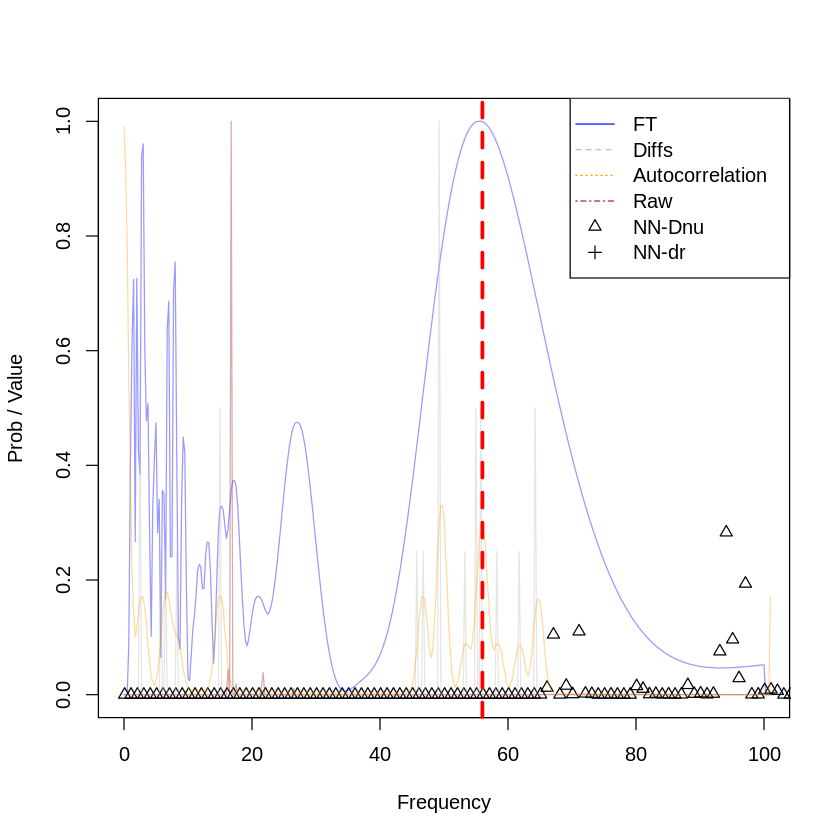

In [136]:
d <- read.csv(paste0(stars_base_dir,"CID100866999.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 56)
errors <- rbind(errors, data.frame("star"="CID100866999", "difference"=56-max, "n"=dim(d)[1]))

## CID105906206.lis

V1,V2
9.4175,2.552
9.0696,2.296
10.7776,2.150
5.6119,1.160
8.9203,0.906
0.1192,0.880


[1] "Nrows: 202"


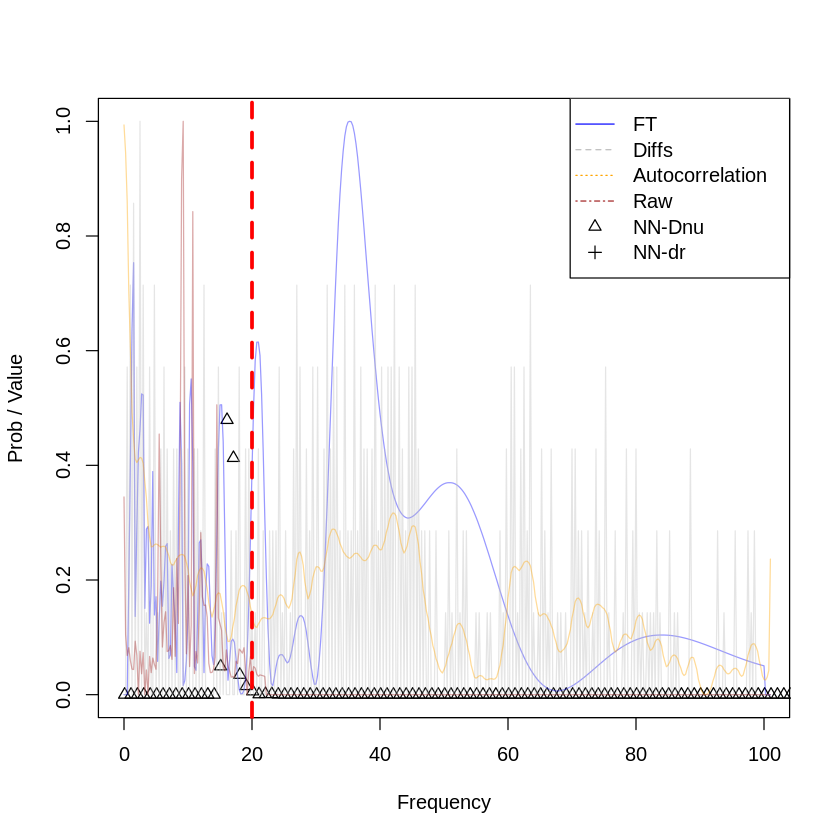

In [137]:
d <- read.csv(paste0(stars_base_dir,"CID105906206.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 20)
errors <- rbind(errors, data.frame("star"="CID105906206", "difference"=20-max, "n"=dim(d)[1]))

## HD15082.lis

V1,V2
20.163899,0.05826439
9.842703,0.05056994
21.064683,0.04185181
1.901497,0.04169184
14.207774,0.04024543
1.028524,5.41987344


[1] "Nrows: 71"


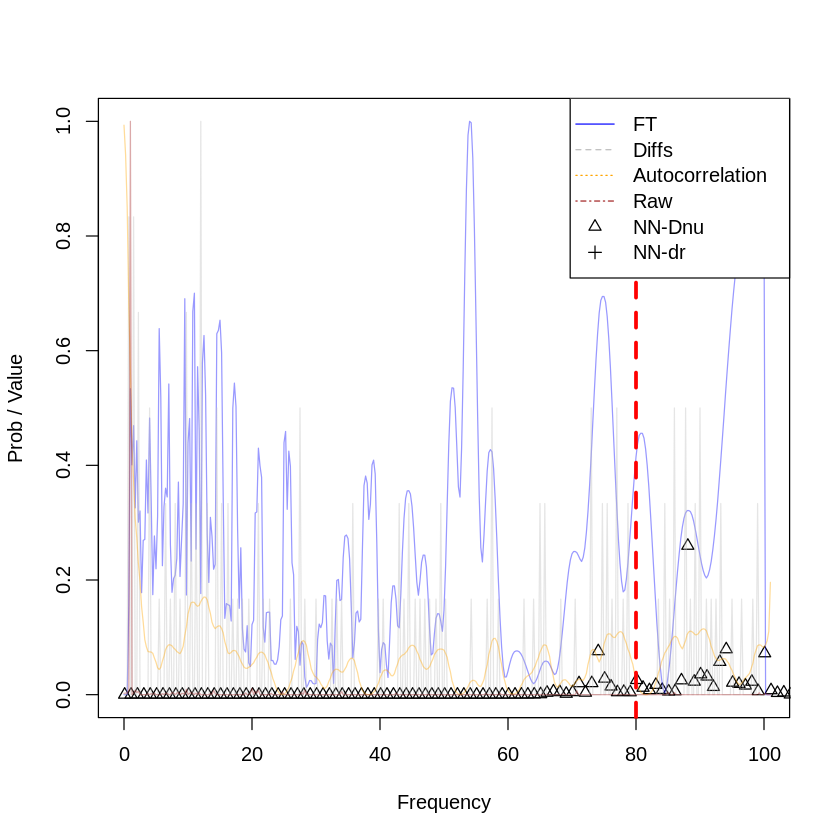

In [138]:
d <- read.csv(paste0(stars_base_dir,"HD15082.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 80, 30)
errors <- rbind(errors, data.frame("star"="HD15082", "difference"=80-max, "n"=dim(d)[1]))

## HD159561.lis

V1,V2
10.227,0.091
10.469,0.104
10.619,0.243
11.720,0.405
13.096,0.144
16.124,0.349


[1] "Nrows: 40"


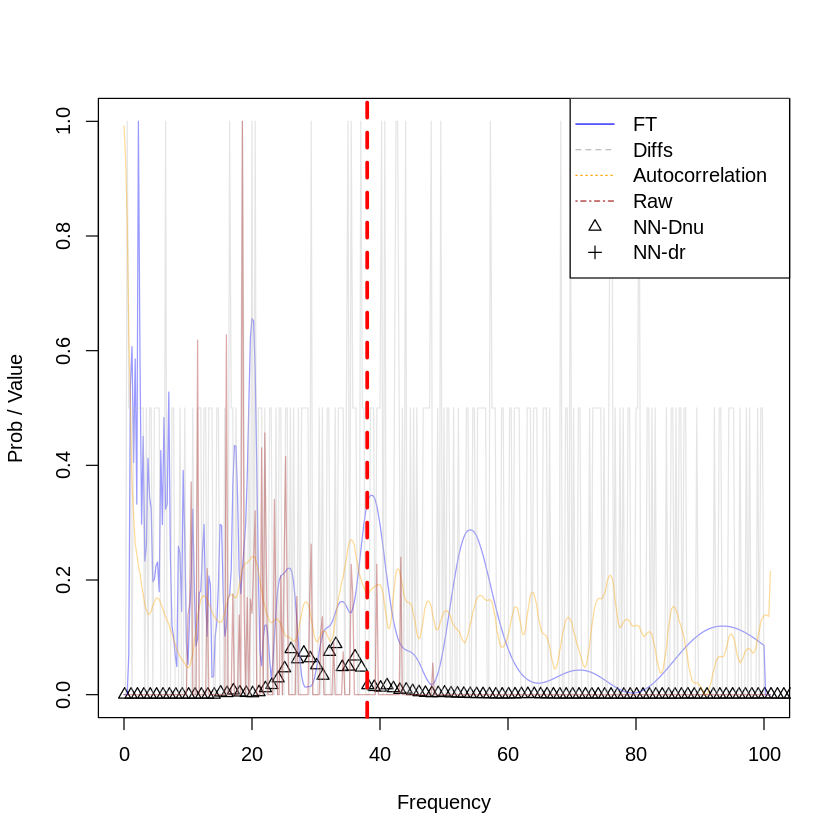

In [139]:
d <- read.csv(paste0(stars_base_dir,"HD159561.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 38)
errors <- rbind(errors, data.frame("star"="HD159561", "difference"=38-max, "n"=dim(d)[1]))

## HD172189.lis

V1,V2
19.58317,4.513889e-05
17.32212,7.523148e-05
17.94392,7.754630e-05
17.84847,7.986111e-05
19.47873,8.333333e-05
18.02352,1.053241e-04


[1] "Nrows: 50"


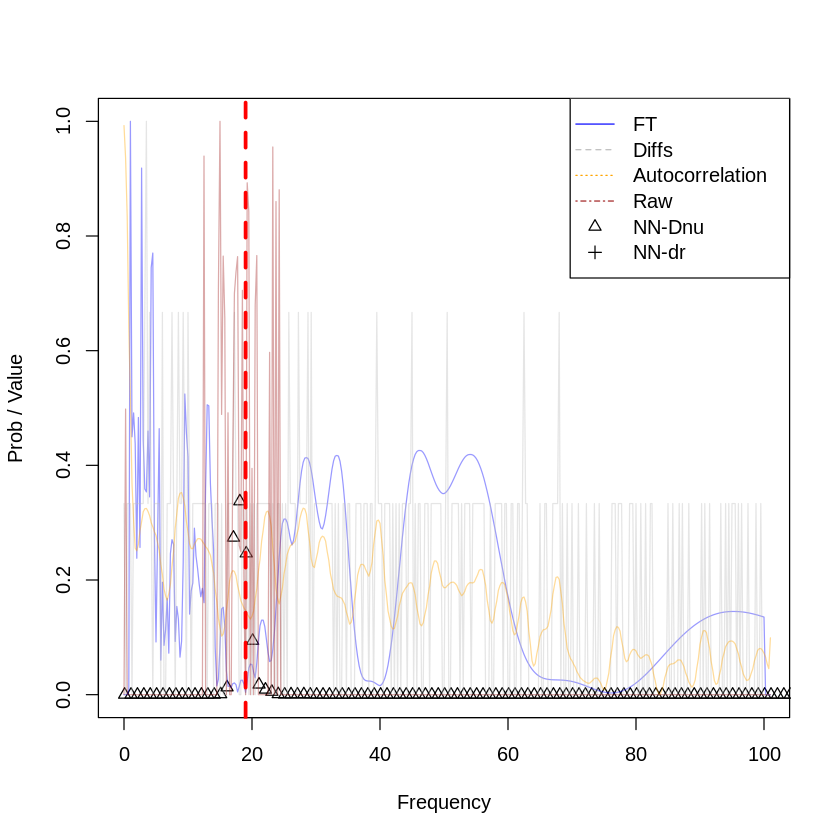

In [140]:
d <- read.csv(paste0(stars_base_dir,"HD172189.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))


max <- validate_real_star(d, 19)
errors <- rbind(errors, data.frame("star"="HD172189", "difference"=19-max, "n"=dim(d)[1]))

## KIC10080943.lis

V1,V2
13.94759,1360.9
3.33350,1321.8
15.68333,1241.7
12.45258,931.5
12.89054,758.4
17.30504,616.1


[1] "Nrows: 321"


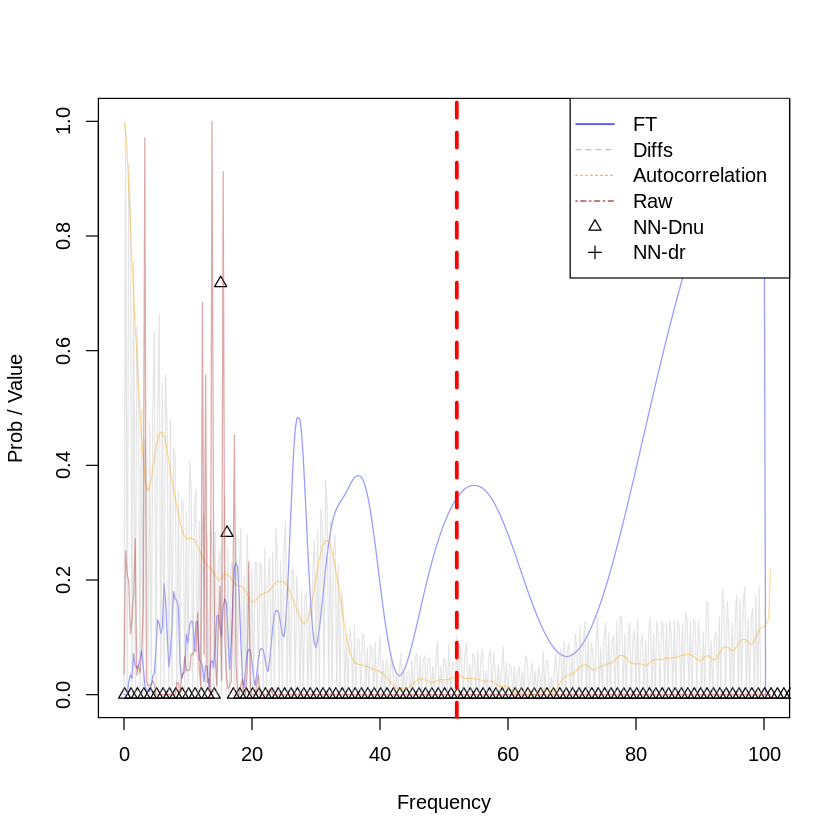

In [141]:
d <- read.csv(paste0(stars_base_dir,"KIC10080943.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 52, 200)
errors <- rbind(errors, data.frame("star"="KIC10080943", "difference"=52-max, "n"=dim(d)[1]))

## kic10661783.lis

V1,V2
28.134,3.07
22.338,3.56
29.383,2.67
25.902,2.02
27.810,0.91
24.407,2.34


[1] "Nrows: 12"


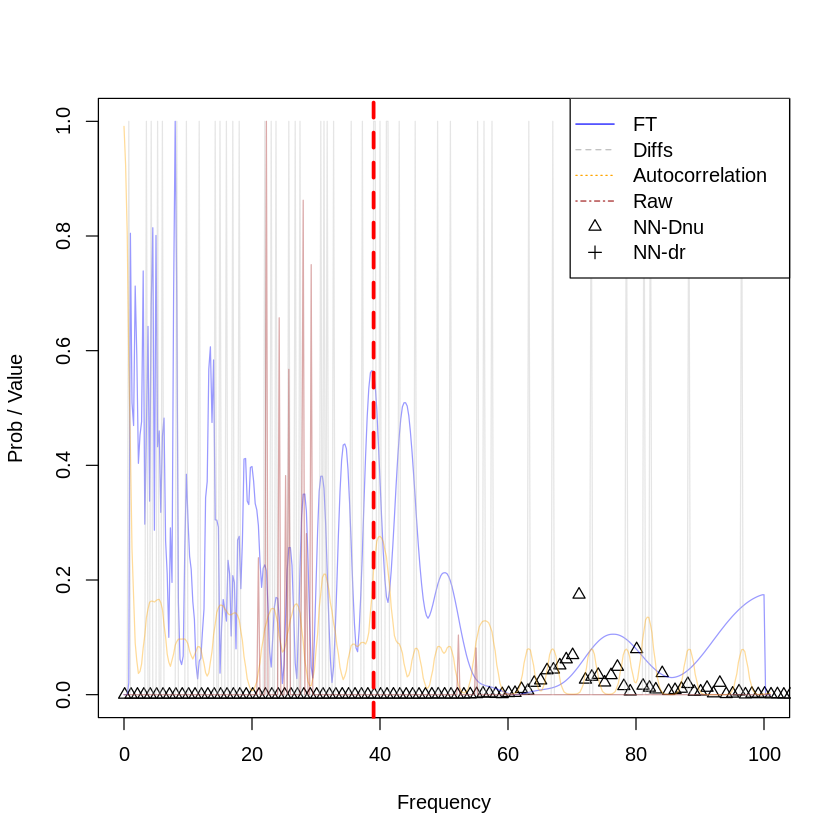

In [142]:
d <- read.csv(paste0(stars_base_dir,"kic10661783.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 39, 30)
errors <- rbind(errors, data.frame("star"="kic10661783", "difference"=39-max, "n"=dim(d)[1]))

## KIC3858884.lis

V1,V2
7.2306,10.15
7.4734,9.10
9.8376,1.96
7.5125,1.75
6.7358,1.55
9.5191,1.24


[1] "Nrows: 400"


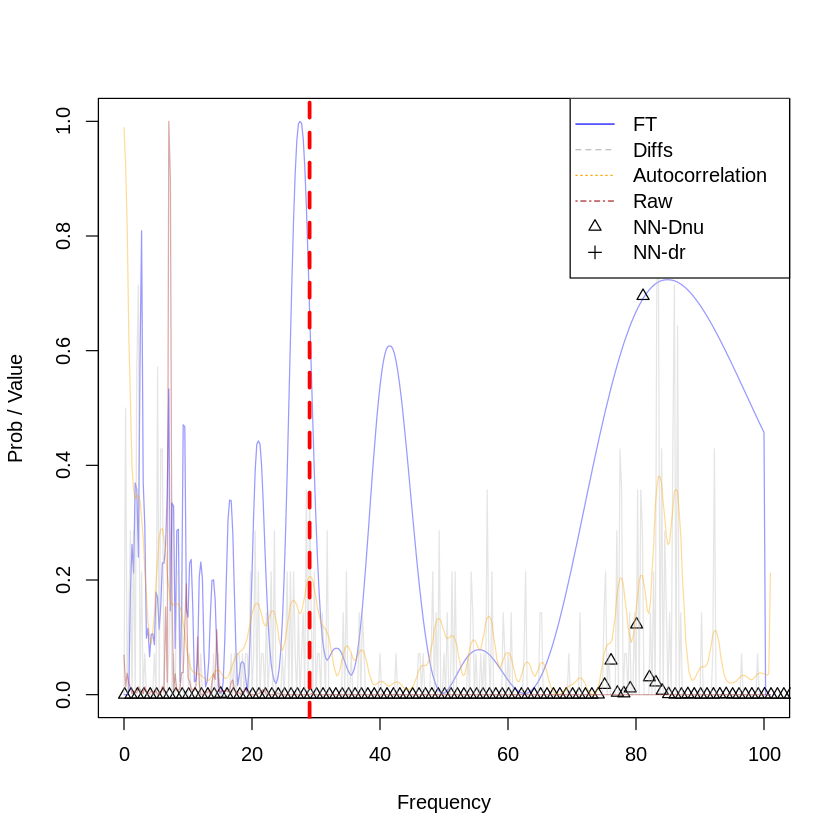

In [143]:
d <- read.csv(paste0(stars_base_dir,"KIC3858884.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 29)
errors <- rbind(errors, data.frame("star"="KIC3858884", "difference"=29-max, "n"=dim(d)[1]))

## kic4544587.lis

V1,V2
48.02231,0.329
41.37020,0.236
44.84695,0.181
46.19662,0.152
48.04449,0.122
39.54280,0.106


[1] "Nrows: 16"


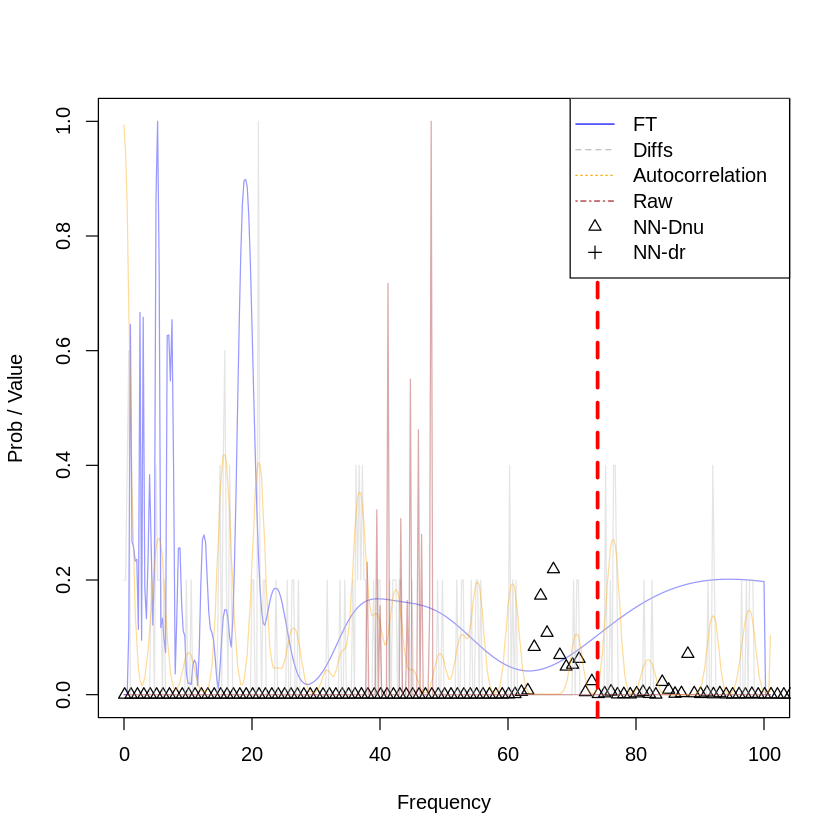

In [144]:
d <- read.csv(paste0(stars_base_dir,"kic4544587.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 74)
errors <- rbind(errors, data.frame("star"="kic4544587", "difference"=74-max, "n"=dim(d)[1]))

## KIC8262223.lis

V1,V2
64.43390,1.319
57.17794,0.918
61.43616,0.782
53.64792,0.620
51.04548,0.565
54.78183,0.540


[1] "Nrows: 60"


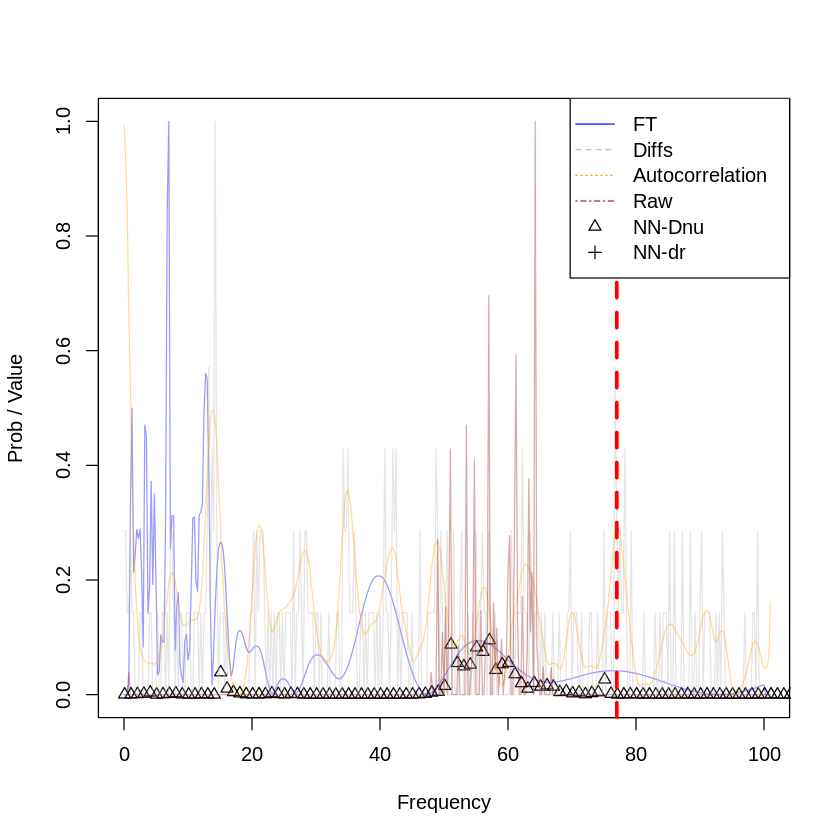

In [145]:
d <- read.csv(paste0(stars_base_dir,"KIC8262223.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 77)
errors <- rbind(errors, data.frame("star"="KIC8262223", "difference"=77-max, "n"=dim(d)[1]))

## KIC9851944.lis

V1,V2
10.399692,0.6530
10.176019,0.5480
11.890476,0.4540
5.097099,0.4046
11.018543,0.2290
12.814916,0.2232


[1] "Nrows: 52"


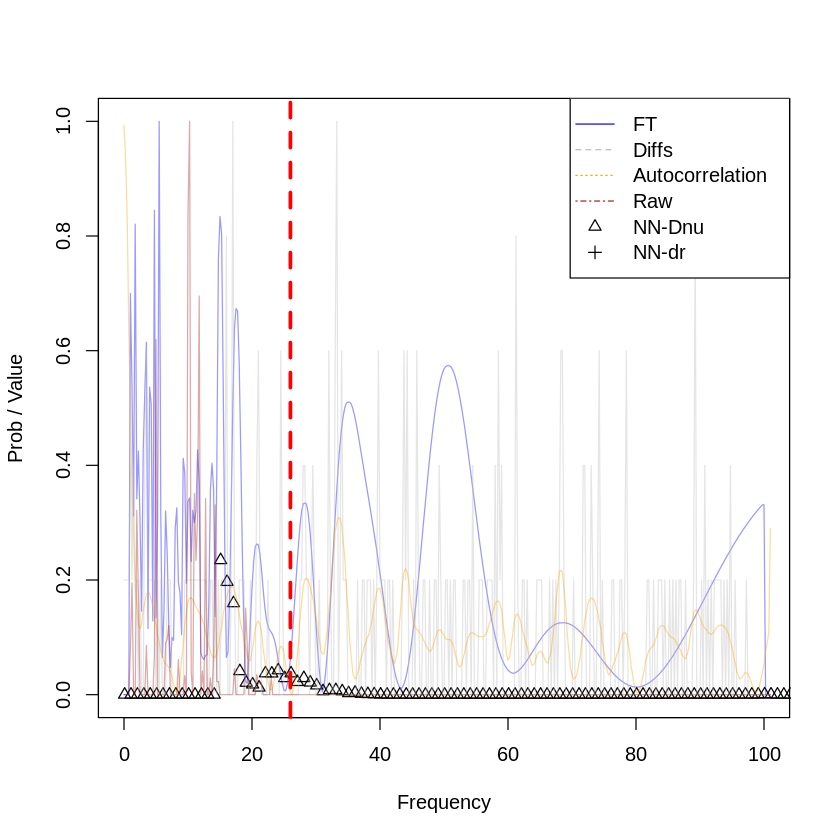

In [146]:
d <- read.csv(paste0(stars_base_dir,"KIC9851944.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 26, 30)
errors <- rbind(errors, data.frame("star"="KIC9851944", "difference"=26-max, "n"=dim(d)[1]))

## All errors

In [147]:
errors
mean(errors$difference)
mean((errors$difference)^2)

star,difference,n
CID100866999,-39,8
CID105906206,3,202
HD15082,-9,71
HD159561,4,40
HD172189,0,50
KIC10080943,36,321
kic10661783,-33,12
KIC3858884,-53,400
kic4544587,6,16
KIC8262223,19,60


[1] -5.090909

[1] 665.2727

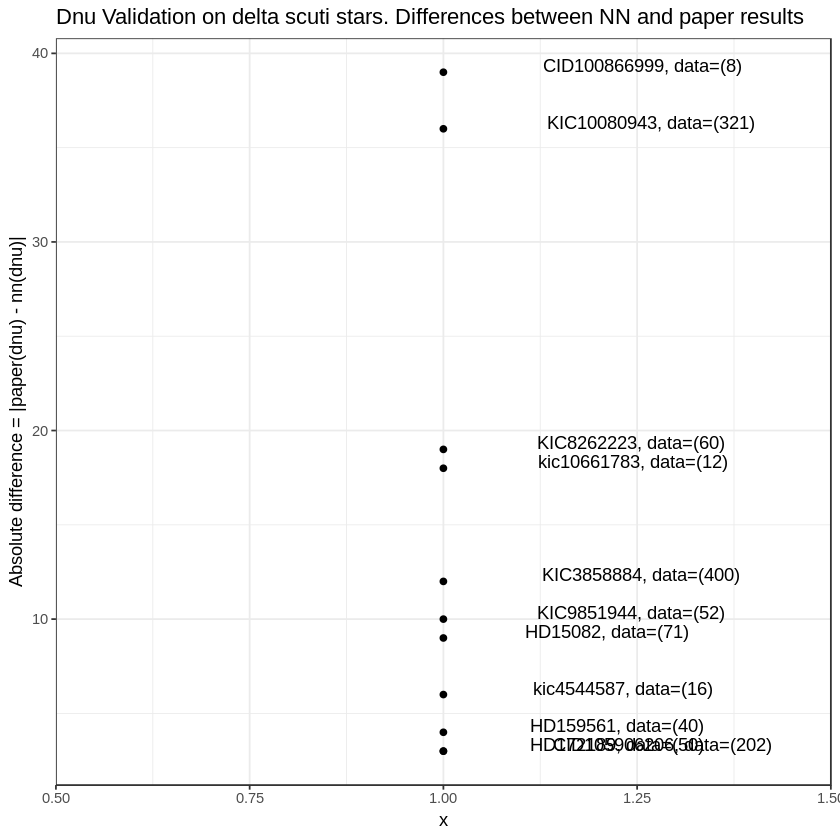

In [131]:
ggplot(aes(y=abs(difference), x=1), data=errors) +
    geom_point() +
    geom_text(aes(label=paste0(star,", data=(",n,")")),hjust=-0.5, vjust=0) +
    ggtitle("Dnu Validation on delta scuti stars. Differences between NN and paper results") +
    ylab("Absolute difference = |paper(dnu) - nn(dnu)|") +
    theme_bw()

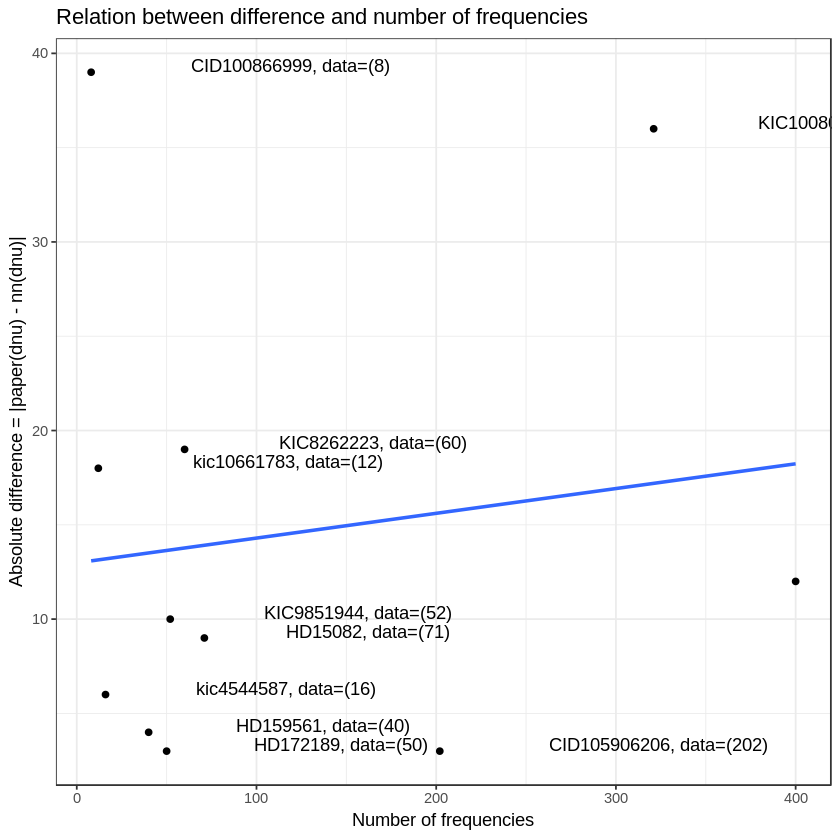

In [132]:
ggplot(aes(y=abs(difference), x=n), data=errors) +
    geom_point()  +
     stat_smooth(method="lm", se=F) +
     geom_text(aes(label=paste0(star,", data=(",n,")")),hjust=-0.5, vjust=0) +
     ggtitle("Relation between difference and number of frequencies") +
     ylab("Absolute difference = |paper(dnu) - nn(dnu)|") +
     xlab("Number of frequencies") +
     theme_bw()